In this section, I will try to find a possible customer segmentation enabling to classify customers according to their different purchases. This should be useful for the next prediction task. Since there are thousands of products in the dataset, I will rely on aisles, which represent categories of products. Even with aisles, features will be too much so I will use PCA to find new dimensions along which clustering will be easier. I will then try to find possible explanations for the identified clusters.

Initial Exploration

In [1]:
import numpy as np 
import pandas as pd 

In [2]:
import os
print('\n'.join(os.listdir()))


aisles.csv
Customer Segments with PCA.ipynb
Data Exploration.ipynb
departments.csv
orders.csv
order_products__prior.csv
order_products__train.csv
products.csv


In [3]:
orders = pd.read_csv('orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [4]:
prior = pd.read_csv('order_products__prior.csv')
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
train = pd.read_csv('order_products__train.csv')
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


This is my understanding of the dataset structure:

~Users are identified by user_id in the orders.csv file. Each row of the orders.csv file represents an order made by a user. Order are identified by order_id.
~Each order of a user is characterized by an order_number which specifies when it has been made with respect to the others of the same user.
~Each order consists of a set of product each characterized by an add_to_cart_order feature representing the sequence in which they have been added to the cart in that order.
~For each user we may have n - 1 prior orders and 1 train order OR n - 1 prior orders and 1 test order in which we have to state what products have been reordered.

In [6]:
order_prior = pd.merge(prior,orders,on=['order_id','order_id'])
order_prior = order_prior.sort_values(by=['user_id','order_id'])
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
4089398,431534,196,1,1,1,prior,5,4,15,28.0
4089399,431534,12427,2,1,1,prior,5,4,15,28.0
4089400,431534,10258,3,1,1,prior,5,4,15,28.0
4089401,431534,25133,4,1,1,prior,5,4,15,28.0
4089402,431534,10326,5,0,1,prior,5,4,15,28.0


In [7]:
products = pd.read_csv('products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
aisles = pd.read_csv('aisles.csv')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [9]:
print(aisles.shape)

(134, 2)


In [10]:

# Read and optimize orders
orders = pd.read_csv('orders.csv', dtype={
    'order_id': 'int32',
    'user_id': 'int32',
    'order_number': 'int16',
    'order_dow': 'int8',
    'order_hour_of_day': 'int8',
    'days_since_prior_order': 'float32'
})

# Read and optimize products
products = pd.read_csv('products.csv', dtype={
    'product_id': 'int32',
    'product_name': 'category',
    'aisle_id': 'int16',
    'department_id': 'int8'
})

# Read and optimize aisles
aisles = pd.read_csv('aisles.csv', dtype={
    'aisle_id': 'int16',
    'aisle': 'category'
})


In [11]:
dtypes_prior = {
    'order_id': 'int32',
    'product_id': 'int32',
    'add_to_cart_order': 'int16',
    'reordered': 'int8'
}

chunksize = 500_000
output_file = 'mt_merged.csv'
write_header = True
chunk_num = 0

for chunk in pd.read_csv('order_products__prior.csv', dtype=dtypes_prior, chunksize=chunksize):
    # Step-by-step merges
    temp = pd.merge(chunk, products, on='product_id', how='left')
    
    # Reduce memory by trimming unnecessary columns from orders before merge
    temp_orders = orders[['order_id', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day']].copy()
    temp = pd.merge(temp, temp_orders, on='order_id', how='left')
    
    temp = pd.merge(temp, aisles, on='aisle_id', how='left')
    
    temp.to_csv(output_file, mode='a', index=False, header=write_header)
    write_header = False
    chunk_num += 1
    print(f"✅ Processed chunk {chunk_num}")

print("🎉 All chunks processed and saved to 'mt_merged.csv'")


✅ Processed chunk 1
✅ Processed chunk 2
✅ Processed chunk 3
✅ Processed chunk 4
✅ Processed chunk 5
✅ Processed chunk 6
✅ Processed chunk 7
✅ Processed chunk 8
✅ Processed chunk 9
✅ Processed chunk 10
✅ Processed chunk 11
✅ Processed chunk 12
✅ Processed chunk 13
✅ Processed chunk 14
✅ Processed chunk 15
✅ Processed chunk 16
✅ Processed chunk 17
✅ Processed chunk 18
✅ Processed chunk 19
✅ Processed chunk 20
✅ Processed chunk 21
✅ Processed chunk 22
✅ Processed chunk 23
✅ Processed chunk 24
✅ Processed chunk 25
✅ Processed chunk 26
✅ Processed chunk 27
✅ Processed chunk 28
✅ Processed chunk 29
✅ Processed chunk 30
✅ Processed chunk 31
✅ Processed chunk 32
✅ Processed chunk 33
✅ Processed chunk 34
✅ Processed chunk 35
✅ Processed chunk 36
✅ Processed chunk 37
✅ Processed chunk 38
✅ Processed chunk 39
✅ Processed chunk 40
✅ Processed chunk 41
✅ Processed chunk 42
✅ Processed chunk 43
✅ Processed chunk 44
✅ Processed chunk 45
✅ Processed chunk 46
✅ Processed chunk 47
✅ Processed chunk 48
✅

In [13]:
dtypes_mt = {
    'order_id': 'int32',
    'product_id': 'int32',
    'add_to_cart_order': 'int16',
    'reordered': 'int8',
    'product_name': 'category',
    'aisle_id': 'int16',
    'department_id': 'int8',
    'user_id': 'int32',
    'order_number': 'int16',
    'order_dow': 'int8',
    'order_hour_of_day': 'int8',
    'aisle': 'category'
}

mt = pd.read_csv('mt_merged.csv', dtype=dtypes_mt)


In [14]:
mt.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,3,5,9,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,3,5,9,fresh vegetables
2,2,9327,3,0,Garlic Powder,104,13,202279,3,5,9,spices seasonings
3,2,45918,4,1,Coconut Butter,19,13,202279,3,5,9,oils vinegars
4,2,30035,5,0,Natural Sweetener,17,13,202279,3,5,9,baking ingredients


In [15]:
mt['product_name'].value_counts()[0:10]

product_name
Banana                    472565
Bag of Organic Bananas    379450
Organic Strawberries      264683
Organic Baby Spinach      241921
Organic Hass Avocado      213584
Organic Avocado           176815
Large Lemon               152657
Strawberries              142951
Limes                     140627
Organic Whole Milk        137905
Name: count, dtype: int64

In [16]:
len(mt['product_name'].unique())

49677

In [17]:
prior.shape

(32434489, 4)

Clustering Customers

In [18]:
len(mt['aisle'].unique())

134

We are dealing with 134 types of product (aisle).

In [19]:
mt['aisle'].value_counts()[0:10]

aisle
fresh fruits                     3642188
fresh vegetables                 3418021
packaged vegetables fruits       1765313
yogurt                           1452343
packaged cheese                   979763
milk                              891015
water seltzer sparkling water     841533
chips pretzels                    722470
soy lactosefree                   638253
bread                             584834
Name: count, dtype: int64

Fresh fruits and fresh vegetables are the best selling goods.

I want to find possible clusters among the different customers and substitute single user_id with the cluster to which they are assumed to belong. Hope this would eventually increase the next prediction model performance.

Ths first thing to do is creating a dataframe with all the purchases made by each user.

In [2]:
import pandas as pd
chunksize = 100_000  # adjust as needed
chunk_iter = pd.read_csv('mt_merged.csv', chunksize=chunksize)

cust_prod = None

for i, chunk in enumerate(chunk_iter):
    ct = pd.crosstab(chunk['user_id'], chunk['aisle'])

    if cust_prod is None:
        cust_prod = ct
    else:
        # Combine by summing matching user-aisle counts
        cust_prod = cust_prod.add(ct, fill_value=0)

    print(f"Processed chunk {i+1}")

# Convert to sparse to reduce memory usage
cust_prod = cust_prod.astype(pd.SparseDtype("int", fill_value=0))
cust_prod.head(10)


Processed chunk 1
Processed chunk 2
Processed chunk 3
Processed chunk 4
Processed chunk 5
Processed chunk 6
Processed chunk 7
Processed chunk 8
Processed chunk 9
Processed chunk 10
Processed chunk 11
Processed chunk 12
Processed chunk 13
Processed chunk 14
Processed chunk 15
Processed chunk 16
Processed chunk 17
Processed chunk 18
Processed chunk 19
Processed chunk 20
Processed chunk 21
Processed chunk 22
Processed chunk 23
Processed chunk 24
Processed chunk 25
Processed chunk 26
Processed chunk 27
Processed chunk 28
Processed chunk 29
Processed chunk 30
Processed chunk 31
Processed chunk 32
Processed chunk 33
Processed chunk 34
Processed chunk 35
Processed chunk 36
Processed chunk 37
Processed chunk 38
Processed chunk 39
Processed chunk 40
Processed chunk 41
Processed chunk 42
Processed chunk 43
Processed chunk 44
Processed chunk 45
Processed chunk 46
Processed chunk 47
Processed chunk 48
Processed chunk 49
Processed chunk 50
Processed chunk 51
Processed chunk 52
Processed chunk 53
Pr

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,5
8,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,6,0,2,0,0,0,...,0,0,0,0,0,0,0,2,0,19


In [3]:
cust_prod.shape

(206209, 134)

We can then execute Principal Component Analysis to the obtained dataframe. This will reduce the number of features from the number of aisles to 6, the number of principal components I have chosen.

In [5]:
!pip install scikit-learn


   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.7 MB 1.7 MB/s eta 0:00:05
   ---- ----------------------------------- 1.0/8.7 MB 2.0 MB/s eta 0:00:04
   ------- -------------------------------- 1.6/8.7 MB 2.3 MB/s eta 0:00:04
   --------- ------------------------------ 2.1/8.7 MB 2.4 MB/s eta 0:00:03
   ---------- ----------------------------- 2.4/8.7 MB 2.4 MB/s eta 0:00:03
   ------------- -------------------------- 2.9/8.7 MB 2.1 MB/s eta 0:00:03
   -------------- ------------------------- 3.1/8.7 MB 2.1 MB/s eta 0:00:03
   ---------------- ----------------------- 3.7/8.7 MB 2.1 MB/s eta 0:00:03
   ------------------- -------------------- 4.2/8.7 MB 2.1 MB/s eta 0:00:03
   --------------------- ------------------ 4.7/8.7 MB 2.1 MB/s eta 0:00:02
   ---------------------- ----------------- 5.0/8.7 MB 2.1 MB/s eta 0:00:02
   -----------------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)

In [7]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5
0,-24.215659,-2.429427,-2.466370,0.145686,0.269042,-1.432932
1,6.463208,-36.751116,8.382553,-15.097530,-6.920938,-0.978375
2,-7.990302,-2.404383,-11.030064,-0.672230,-0.442368,-2.823272
3,-27.991129,0.755823,-1.921732,-2.091888,-0.288232,0.926177
4,-19.896394,2.637225,0.533229,-3.679228,0.612825,-1.624008


I have plotted several pair of components looking for the one suitable, in my opinion, for a KMeans Clustering. I have chosen the (PC4,PC1) pair. Since each component is the projection of all the points of the original dataset I think each component is representative of the dataset.

(206209, 2)
          4          1
0  0.269042  -2.429427
1 -6.920938 -36.751116
2 -0.442368  -2.404383
3 -0.288232   0.755823
4  0.612825   2.637225


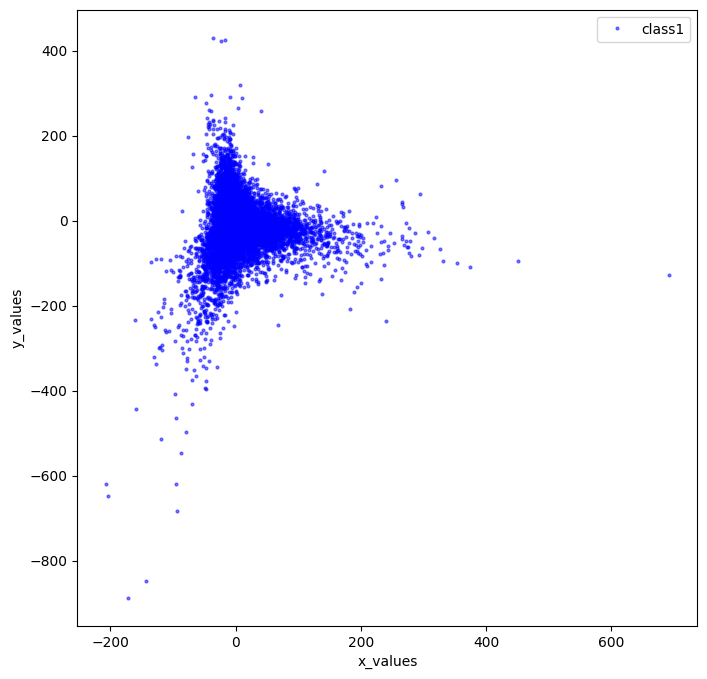

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
tocluster = pd.DataFrame(ps[[4,1]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[4], tocluster[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[ -4.71201841  40.617772  ]
 [ -0.11856333  -0.09813797]
 [-11.27561288 -65.26938505]
 [ 76.8233881  -26.26358548]]


In [10]:
print (c_preds[0:100])

[1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 2 1 1 1 1 1 1 1 1 1 1]


['blue', 'purple', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']


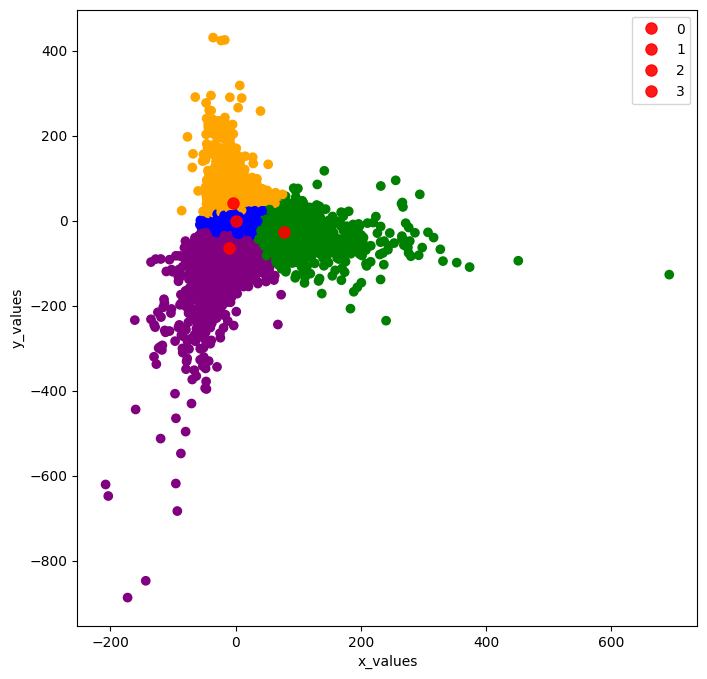

In [11]:
%matplotlib inline
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[4],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

We have found a possible clustering for our customers. Let's check if we also manage to find some interesting pattern beneath it.

In [12]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

clust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,3,0,0,0,0,2,0,0,0,...,1,1,0,0,0,0,2,0,42,2
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,5,1
8,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,6,0,2,0,0,0,...,0,0,0,0,0,0,2,0,19,1


In [13]:
print (clust_prod.shape)


(206209, 135)


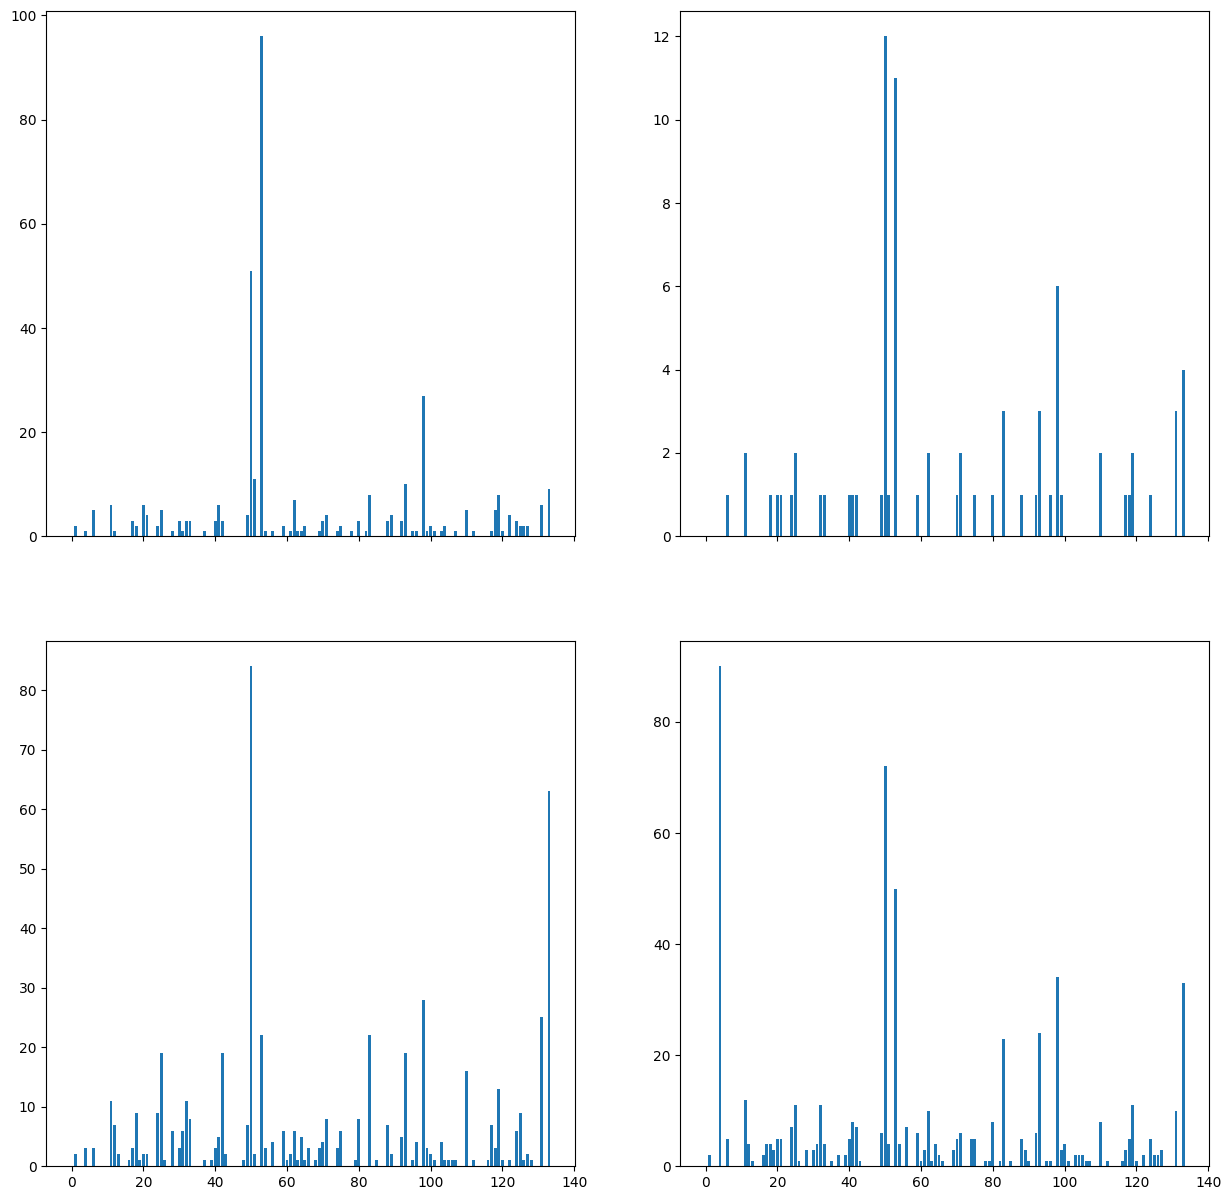

In [14]:
%matplotlib inline
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))

c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)

c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)

c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)

c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)
plt.show()

Let's check out what are the top 10 goods bought by people of each cluster. We are going to rely first on the absolute data and then on a percentage among the top 8 products for each cluster.

In [15]:
c0.sort_values(ascending=False)[0:10]

aisle
fresh vegetables              96
fresh fruits                  51
packaged vegetables fruits    27
fresh herbs                   11
packaged cheese               10
yogurt                         9
milk                           8
soy lactosefree                8
frozen produce                 7
bread                          6
dtype: Sparse[int64, 0]

In [16]:
c1.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     12
fresh vegetables                 11
packaged vegetables fruits        6
yogurt                            4
packaged cheese                   3
milk                              3
water seltzer sparkling water     3
soy lactosefree                   2
ice cream ice                     2
chips pretzels                    2
dtype: Sparse[int64, 0]

In [17]:
c2.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     84
yogurt                           63
packaged vegetables fruits       28
water seltzer sparkling water    25
fresh vegetables                 22
milk                             22
packaged cheese                  19
energy granola bars              19
chips pretzels                   19
refrigerated                     16
dtype: Sparse[int64, 0]

In [18]:
c3.sort_values(ascending=False)[0:10]

aisle
baby food formula             90
fresh fruits                  72
fresh vegetables              50
packaged vegetables fruits    34
yogurt                        33
packaged cheese               24
milk                          23
bread                         12
crackers                      11
chips pretzels                11
dtype: Sparse[int64, 0]

A first analysis of the clusters confirm the initial hypothesis that:

fresh fruits
fresh vegetables
packaged vegetables fruits
yogurt
packaged cheese
milk
water seltzer sparkling water
chips pretzels
are products which are genereically bought by the majority of the customers.

What we can inspect here is if clusters differ in quantities and proportions, with respect of these goods, or if a cluster is characterized by some goods not included in this list. For instance we can already see cluster 3 is characterized by 'Baby Food Formula' product which is a significant difference with respect to the other clusters.

In [19]:
from IPython.display import display, HTML
cluster_means = [[c0['fresh fruits'],c0['fresh vegetables'],c0['packaged vegetables fruits'], c0['yogurt'], c0['packaged cheese'], c0['milk'],c0['water seltzer sparkling water'],c0['chips pretzels']],
                 [c1['fresh fruits'],c1['fresh vegetables'],c1['packaged vegetables fruits'], c1['yogurt'], c1['packaged cheese'], c1['milk'],c1['water seltzer sparkling water'],c1['chips pretzels']],
                 [c2['fresh fruits'],c2['fresh vegetables'],c2['packaged vegetables fruits'], c2['yogurt'], c2['packaged cheese'], c2['milk'],c2['water seltzer sparkling water'],c2['chips pretzels']],
                 [c3['fresh fruits'],c3['fresh vegetables'],c3['packaged vegetables fruits'], c3['yogurt'], c3['packaged cheese'], c3['milk'],c3['water seltzer sparkling water'],c3['chips pretzels']]]
cluster_means = pd.DataFrame(cluster_means, columns = ['fresh fruits','fresh vegetables','packaged vegetables fruits','yogurt','packaged cheese','milk','water seltzer sparkling water','chips pretzels'])
HTML(cluster_means.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,51,96,27,9,10,8,6,5
1,12,11,6,4,3,3,3,2
2,84,22,28,63,19,22,25,19
3,72,50,34,33,24,23,10,11


The following table depicts the percentage these goods with respect to the other top 8 in each cluster. It is easy to some interesting differences among the clusters.

It seems people of cluster 0 buy more fresh vegetables than the other clusters. As shown by absolute data, Cluster 0 is also the cluster including those customers buying far more goods than any others.

People of cluster 2 buy more yogurt than people of the other clusters.

Absolute Data shows us People of cluster 3 buy a Lot of 'Baby Food Formula' which not even listed in the top 8 products but mainly characterize this cluster. Coherently (I think) with this observation they buy more milk than the others.

In [20]:
cluster_perc = cluster_means.iloc[:, :].apply(lambda x: (x / x.sum())*100,axis=1)
HTML(cluster_perc.to_html())


,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,24.056604,45.283019,12.735849,4.245283,4.716981,3.773585,2.830189,2.358491
1,27.272727,25.000000,13.636364,9.090909,6.818182,6.818182,6.818182,4.545455
2,29.787234,7.801418,9.929078,22.340426,6.737589,7.801418,8.865248,6.737589
3,28.015564,19.455253,13.229572,12.840467,9.338521,8.949416,3.891051,4.280156


I think another interesting information might come by looking at the 10th to 15th most bought products for each cluster which will not include the generic products (i.e. vegetables, fruits, water, etc.) bought by anyone.

In [21]:
c0.sort_values(ascending=False)[10:15]

aisle
eggs                             6
canned jarred vegetables         6
water seltzer sparkling water    6
refrigerated                     5
soup broth bouillon              5
dtype: Sparse[int64, 0]

In [22]:
c1.sort_values(ascending=False)[10:15]

aisle
frozen produce            2
bread                     2
refrigerated              2
paper goods               1
hot dogs bacon sausage    1
dtype: Sparse[int64, 0]

In [23]:
c2.sort_values(ascending=False)[10:15]

aisle
soy lactosefree    13
crackers           11
bread              11
tea                 9
cereal              9
dtype: Sparse[int64, 0]

In [24]:
c3.sort_values(ascending=False)[10:15]

aisle
soy lactosefree                  11
water seltzer sparkling water    10
frozen produce                   10
lunch meat                        8
eggs                              8
dtype: Sparse[int64, 0]

As you can note by taking into account more products clusters start to differ significantly.